## Exploratory Data Analysis Of Merchant Historical Transactions

### Introduction

The goal of this exploratory data analysis is to gain an understanding of the merchant transactions dataset, which contains detailed records of historical transactions. By analyzing this data, I aim to uncover key insights related to merchant popularity, geographical trends, sales performance, and other factors that could impact a merchant’s business.

Throughout this analysis, I will focus on answering important questions such as:

- Insight into monthly merchant sales for each city in the dataset
- Merchant popularity and their locations
- What are the most popular merchant categories?
- Are there correlations between merchant categories and specific locations?


### Familiarizing with the Dataset

In this analysis, two key data sources were used: **a Merchants CSV file** and **a Historical Transactions Parquet** file. Each dataset was explored and cleaned to prepare for the subsequent analysis.

**1. Merchants CSV**
- Total rows: 334,696
- Distinct merchant IDs: 334,633

After analysis of the dataset and its relation to the historical transactions, it was decided to **drop non-distinct merchant IDs**. Although this resulted in the loss of some merchant names, it was beneficial for simplifying the join operation with the historical transactions. By removing duplicates, we avoided having a many-to-many relationship during the join, improving the **precision of numerical values** when calculating total sums. The cleaned Merchants CSV dataset was used for further analysis.

**2. Historical Transactions Parquet File**
- Total rows: 7,274,367
- Null merchant IDs: 34,570
- Null categories: 44,625

For the historical transactions dataset, the following steps were taken:

- Handling Null Merchant IDs: Rows with null merchant IDs got this column replaced by a newly generated merchant IDs, as the other data in these rows were valuable for the analysis.
- Handling Null Categories: Rows with null categories had these values replaced to "Unknown category" to avoid losing useful data.
- Column Renaming: Certain columns were renamed for better readability and ease of use when joining the historical transactions with the merchants dataset.
- Date Processing: The purchase_amount_date column was split into year, month, and hour for easier grouping and analysis.

**3. Joining the Datasets**

The Merchants CSV dataset was left joined to the Historical Transactions dataset on the **merchant_id** column. A few specific transformations were applied during this process:

- Handling Null Merchant Names: For historical transactions with no matching merchant in the merchants dataset (resulting in merchant_name being null), the merchant_id was used as the merchant_name to retain the usefulness of these rows.
- Handling City and State IDs: Some rows in the merchants dataset had missing or invalid city_id and state_id values (null or -1), while the same merchants had proper city and state IDs in the historical transactions. To resolve this:
    - A new final_city_id and final_state_id column was introduced.
    - If the city_id and state_id were available in the historical transactions, these values were used.
    - If the information was missing in the historical transactions, the values from the merchants dataset were used.
    - If neither dataset contained valid values, -1 was assigned to both the final_city_id and final_state_id.


These steps ensured that the dataset was clean, consistent, and ready for detailed analysis.

Following code cell represents cleaning and transformation mentioned in the familiarization with the dataset and as well the base that all the reports use.

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def create_spark_session():
    return SparkSession.builder \
        .appName("MyApp") \
        .master("local[*]") \
        .config("spark.sql.warehouse.dir", "/tmp") \
        .config("spark.hadoop.security.authentication", "simple") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()

def merge_columns(col1, col2):
    return F.when(F.col(col1).isNotNull() & (F.col(col1) != -1), F.col(col1)) \
            .otherwise(F.when(F.col(col2).isNotNull() & (F.col(col2) != -1), F.col(col2))
            .otherwise(F.lit(-1))
        )

def replace_null_merchant_name_with_id(df):
    df_filled = df.withColumn(
        "merchant_name",
        F.when(F.col("merchant_name").isNull(), F.col("ht_merchant_id"))
        .otherwise(F.col("merchant_name"))
    )
    
    return df_filled

def rename_ht_columns_for_join(df):
    return df.withColumnRenamed("merchant_id", "ht_merchant_id") \
             .withColumnRenamed("city_id", "ht_city_id") \
             .withColumnRenamed("state_id", "ht_state_id")

def generate_id_for_null_values(df):
    return df.withColumn(
            "merchant_id",
            F.when(F.col("merchant_id").isNull(), F.concat(F.lit("G_ID_"), F.expr("substring(cast(monotonically_increasing_id() as string), -10, 10)")))
            .otherwise(F.col("merchant_id"))
        )

def initialize_null_categories(df):
    return df.na.fill("Unknown category", subset=["category"])

def parse_date_column(df):
    df = df.withColumn("date", F.to_date("purchase_date", "yyyy-MM-dd HH:mm:ss"))
    return df.withColumn("year", F.year("date")) \
             .withColumn("month", F.month("date")) \
             .withColumn("hour", F.hour(F.col("purchase_date")))


parquet_file_path = "historical-transactions.snappy.parquet"
csv_file_path = "merchants-subset.csv"
spark = create_spark_session()

df_historical_merchants_transactions = spark.read.parquet(parquet_file_path)
df_merchants = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csv_file_path)

df_merchants = df_merchants.dropDuplicates(["merchant_id"])
df_historical_merchants_transactions = generate_id_for_null_values(df_historical_merchants_transactions)
df_historical_merchants_transactions = initialize_null_categories(df_historical_merchants_transactions)
df_historical_merchants_transactions = rename_ht_columns_for_join(df_historical_merchants_transactions)

joined_df = df_historical_merchants_transactions.join(df_merchants, df_historical_merchants_transactions["ht_merchant_id"] == df_merchants["merchant_id"], "left")

joined_df = joined_df.withColumn("final_city_id", merge_columns("ht_city_id", "city_id")) \
                     .withColumn("final_state_id", merge_columns("ht_state_id", "state_id"))

joined_df = parse_date_column(joined_df)
joined_df = replace_null_merchant_name_with_id(joined_df)

### TOP FIVE MERCHANTS FOR EACH MONTH IN THE DATASET, FOR EACH CITY IN THE DATASET

The goal of this task was to identify the top five merchants by total sales for each month and for each city in the dataset. To achieve this, I've done the following:

- Grouped the transactions by **year**, **month**, **final_city_id**, and **merchant_id** to aggregate the total sales and number of sales for each merchant in each city during each month.
- Using a window function partitioned by **year**, **month**, and **final_city_id**, I ranked the merchants in descending order based on their total sales. This allows us to assign ranks to each merchant within their respective city and month. After assigning ranks, I filtered the results to keep only the **top 5 merchants for each city in each month**.
- I then sorted the results by year, month, final_city_id, and rank, ensuring that the final output would be organized for easy interpretation. The total_sales column was formatted to two decimal places, and a new month_year column was created to improve readability in the final report.

Deduction that can be done based on the report:

- Merchant dominance in cities
    - Which merchants consistently perform well in certain cities. For example if a merchant frequently appears in the top five across multiple months, it suggests its high value and this information could be useful for different business strategies.
- Seasonal or Monthly Trends:
    - By examining the top merchants across months, we can identify whether certain merchants experience seasonal sales peaks. Merchants in certain categories my dominate sales during particular months. (Holidays, special events)
- Cities with a high concentration of top-performing merchants might indicate stronger markets for certain industries and categories. 



In [31]:
df_grouped = joined_df.groupBy("year", "month", "final_city_id", "merchant_id") \
                            .agg(F.sum("purchase_amount").alias("total_sales"),
                                 F.count("purchase_amount").alias("no_of_sales"),
                                 F.first("merchant_name").alias("merchant_name"))

window_spec = Window.partitionBy("year", "month", "final_city_id").orderBy(F.desc("total_sales"))
df_ranked = df_grouped.withColumn("rank", F.rank().over(window_spec))


df_top_5 = df_ranked.filter(F.col("rank") <= 5)

df_sorted = df_top_5.orderBy(F.col("year").desc(),F.col("month").asc(),F.col("final_city_id").asc(),F.col("rank").asc())

df_sorted = df_sorted.withColumn("total_sales", F.format_number("total_sales", 2))
df_formatted = df_sorted.withColumn(
    "month_year",
    F.concat(F.date_format(F.concat(F.col("year"), F.lit("-"), F.col("month")), "MMM"), F.lit(" "), F.col("year"))
)

df_final_report_select = df_formatted.select(
    F.col("month_year").alias("Month"),
    F.col("final_city_id").alias("City"),
    F.col("merchant_name").alias("Merchant"),
    F.col("total_sales").alias("Purchase Total"),
    F.col("no_of_sales").alias("No of sales")
    )

df_final_report_select.show(30)


+--------+----+--------------------+--------------+-----------+
|   Month|City|            Merchant|Purchase Total|No of sales|
+--------+----+--------------------+--------------+-----------+
|Jan 2018|   1|  Kathie Sughrue inc|267,943,521.12|      13326|
|Jan 2018|   1|      Cesar Hall inc|192,160,428.46|       9557|
|Jan 2018|   1|     Mary Gray 7 inc|102,481,787.09|       5072|
|Jan 2018|   1| David Gunstream inc| 51,971,242.09|       2572|
|Jan 2018|   1|  Steven Russell inc| 47,455,288.85|       2342|
|Jan 2018|   2|     Shana Platt inc|    603,751.09|         28|
|Jan 2018|   2|    James Luhman inc|    468,621.16|         23|
|Jan 2018|   2|   Charles Budde inc|    306,296.72|         16|
|Jan 2018|   2|Ernesto Matthews inc|    293,381.94|         13|
|Jan 2018|   2|  Cristal Forney inc|    252,781.38|         13|
|Jan 2018|   3|Rhonda Cunningham...|    885,905.56|         44|
|Jan 2018|   3| Donnie Sefcovic inc|    778,974.19|         35|
|Jan 2018|   3| Dennis Mcmillan inc|    

### AVERAGE SALE AMOUNT FOR EACH MERCHANT IN EACH STATE, ORDERED  BY LARGEST AVERAGE SALES.

Deduction that can be done based on the report:

If a merchant appears in the top spots in many states, this could mean that their business model works well across different regions, and they have a product or service that appeals to a broad group of people willing to make expensive purchases. This means:

- The merchant's product or services might be valuable to people in many places indicating they are a popular brand.
- People in multiple states are spending more money with these merchants compared to others meaning that the mearchant has a wider appeal with consumers who don't mind spending a lot in one go.

If a new merchant approached us for consultancy regarding their business, I would use this report to analyze similar business models and how well they perform across different states. By examining merchants with comparable products or services, we could provide insights into where the business might thrive and suggest optimal locations for expansion based on the performance of similar merchants in various regions.


In [32]:
parquet_file_path = "historical-transactions.snappy.parquet"
csv_file_path = "merchants-subset.csv"

df_grouped_state = joined_df.groupBy("final_state_id", "merchant_id") \
                            .agg(F.avg("purchase_amount").alias("avg_purchase_amount"),
                                 F.first("merchant_name").alias("merchant_name")) \
                            .orderBy(F.desc("avg_purchase_amount"))

df_grouped_state = df_grouped_state.withColumn("avg_purchase_amount", F.format_number("avg_purchase_amount", 2))

df_merchant_state_avg_select = df_grouped_state.select(
    F.col("merchant_name").alias("Merchant"),
    F.col("final_state_id").alias("State ID"),
    F.col("avg_purchase_amount").alias("Average Amount")
)

df_merchant_state_avg_select.show()

+--------------------+--------+--------------+
|            Merchant|State ID|Average Amount|
+--------------------+--------+--------------+
|  Martha Tyrrell inc|       7|     39,937.61|
|  Julie Mckelvey inc|       9|     39,727.59|
|   Jennifer Pool inc|      24|     39,658.71|
|    Ileana Owens inc|       9|     39,649.56|
|  Robert Mullins inc|      15|     39,642.69|
|Christopher Hamil...|      20|     39,602.72|
|      Raul Creed inc|       2|     39,569.62|
|    Samuel Evans inc|      15|     39,558.60|
|  Dawn Ellington inc|      16|     39,556.68|
|   Pamela Ulrich inc|      13|     39,556.68|
| Mario Marroquin inc|       5|     39,550.66|
| Gertrude Leslie inc|       5|     39,541.60|
|   Dorothy Zemel inc|      16|     39,532.16|
|William Harris 2 inc|       4|     39,531.70|
| Thomas Wright 3 inc|       7|     39,502.42|
|     Anna Glover inc|       9|     39,462.52|
|  Ashley Schmidt inc|       9|     39,444.30|
|      Larry Teig inc|       4|     39,432.73|
|      Mike W

### TOP THREE HOURS WHERE THE LARGEST AMOUNT OF SALES ARE RECORDED FOR EACH PRODUCT CATEGORY

For each product category, we now have a clear view of the hours during which the highest amount of sales was recorded. These peak hours could indicate the times when customers are most engaged with that category, potentially influenced by their daily schedules or buying habits.

This data could also be valuable for operational planning. Businesses could adjust staffing, inventory management, or delivery schedules based on the busiest hours for each category.

In [33]:

df_grouped_category = joined_df.groupBy("category", "hour") \
                            .agg(F.sum("purchase_amount").alias("total_sales"))

window_spec = Window.partitionBy("category").orderBy(F.desc("total_sales"))
df_ranked = df_grouped_category.withColumn("rank", F.rank().over(window_spec))

df_top_3 = df_ranked.filter(F.col("rank") <= 3)


df_sorted_category = df_top_3.orderBy(F.col("category").asc(),F.col("rank").asc())

df_sorted_category = df_sorted_category.withColumn("total_sales", F.format_number("total_sales", 2))

df_category_select = df_sorted_category.select(
    F.col("category").alias("Product Category"),
    F.col("hour").alias("Hour")
)
df_category_select.show()





+----------------+----+
|Product Category|Hour|
+----------------+----+
|               A|  12|
|               A|  13|
|               A|  17|
|               B|  13|
|               B|  12|
|               B|  14|
|               C|  17|
|               C|  16|
|               C|  15|
|Unknown category|   0|
|Unknown category|  14|
|Unknown category|  13|
+----------------+----+



Both **Category A** and **Category B** have significant sales during lunchtime hours (12 PM to 1 PM). This suggests that certain categories of products/services are in high demand during break times, likely due to their convenience or necessity during this period. **Category C** shows a peak during the late afternoon and evening hours, suggesting that this category might consist of products or services that align with leisure or post-work activities. This could be something like dining, entertainment, or other after-hours services.

### CITIES WITH THE MOST POPULAR MERCHANTS. CORRELATION BETWEEN LOCATION AND CATEGORIES THE MERCHANT SELLS.

I first identified the most popular merchants by grouping the data based on the city and merchant ID. I calculated the total number of sales and the total sales amount for each merchant in each city and then ranked the cities based on the total number of sales.

Next, I grouped the data by city and product category, counting the number of distinct merchants operating in each category across different cities. This helped identify cities with the highest concentration of merchants for each category.

+-------------+--------+--------------+
|final_city_id|category|merchant_count|
+-------------+--------+--------------+
|           69|       A|         16589|
|           69|       B|         15467|
|           19|       A|          9671|
|          331|       A|          8206|
|           19|       B|          7933|
|          333|       A|          6771|
|          331|       B|          6746|
|            1|       B|          6700|
|            1|       A|          6690|
|          158|       A|          6662|
|          158|       B|          6130|
|          333|       B|          5446|
|           69|       C|          5324|
|           17|       A|          5143|
|           57|       A|          4517|
+-------------+--------+--------------+
only showing top 15 rows



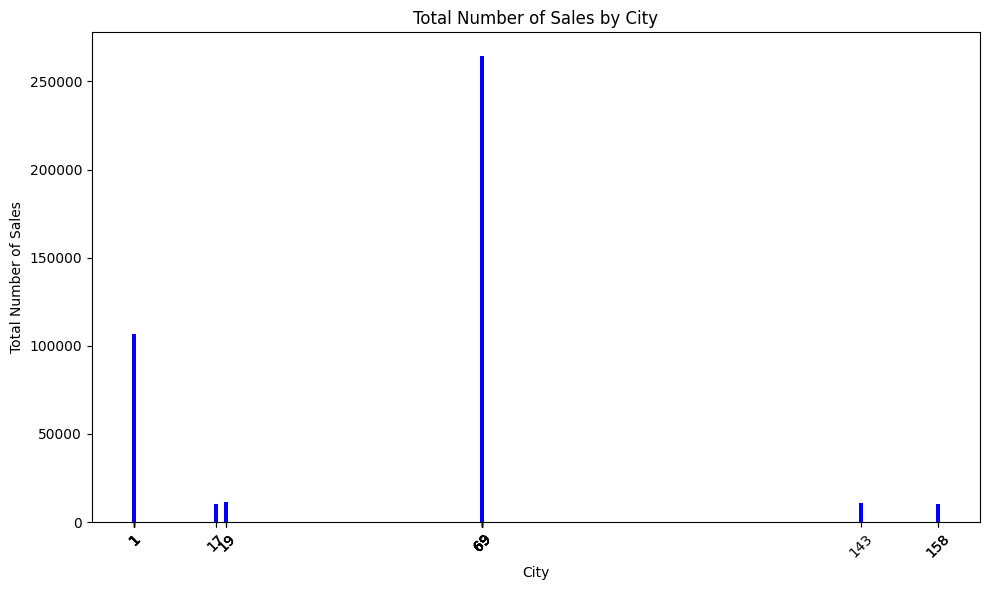

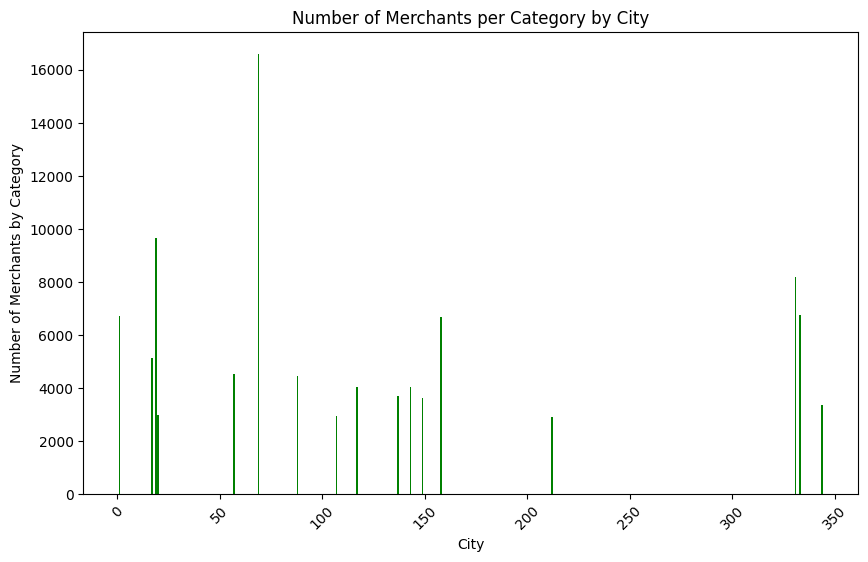

In [34]:
import matplotlib.pyplot as plt

df_city_grouped_general = df_grouped.groupBy("final_city_id", "merchant_id") \
                                   .agg(F.sum("no_of_sales").alias("total_no_of_sales"),
                                        F.sum("total_sales").alias("total_amount_sales"))

df_top_cities_sorted = df_city_grouped_general.orderBy(F.desc("total_no_of_sales"))


df_city_category_distribution = joined_df.groupBy("final_city_id", "category") \
                                         .agg(F.countDistinct("merchant_id").alias("merchant_count"))

df_city_category_distribution = df_city_category_distribution.orderBy(F.desc("merchant_count"))
df_city_category_distribution.show(15)

df_top_cities_pd = df_top_cities_sorted.limit(30).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_top_cities_pd['final_city_id'], df_top_cities_pd['total_no_of_sales'].astype(float), color='blue')
plt.xlabel('City')
plt.ylabel('Total Number of Sales')
plt.title('Total Number of Sales by City')
plt.xticks(df_top_cities_pd['final_city_id'], rotation=45)
plt.tight_layout()
plt.show()

df_city_category_pd = df_city_category_distribution.limit(30).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_city_category_pd['final_city_id'], df_city_category_pd['merchant_count'].astype(float), color='green')
plt.xlabel('City')
plt.ylabel('Number of Merchants by Category')
plt.title('Number of Merchants per Category by City')
plt.xticks(rotation=45)
plt.show()


**Observations:** 
- Cities 1 and 69 dominate the top 20 most popular merchants by sales volume.
- Categories A and B have the highest number of distinct merchants in City 69, and they also appear in large number in City 1. (Most of the cities with the highest number of different merchants for categories A and B make the list of the most popular merchants.)
- Category C also appears in both City 69 and City 1 with high number of different merchants that sell this category. 

Since the most popular merchants (with the highest transaction counts) are concentrated in Cities 1 and 69, it suggests that these cities are likely major economic hubs or regions with high purchasing power. The merchants in these cities dominate because the market environment is favorable for high-volume sales.

The correlation between popular merchants and dominant categories (A and B) could indicate that merchants who specialize in these categories are more likely to be successful in Cities 1 and 69. Therefore, merchants operating in Categories A and B seem to benefit from the existing consumer demand in these cities. 

The presence of category C in these cities might as well that even though that category C might not be that popular, it can still suceeed in a bigger market like the cities 1 and 69 have.

### A new merchant is coming in to do business and you have been assigned to give advice based strictly on the historical transactions.

a. Which cities would you advise them to focus on and why?
- Almost all of the most popular merchants are located in the cities 1 and 69. All categories for these cities seem to be having many different merchants indicating a variety of different products of the same category. This market seems to already be well-formed and focusing these two cities seems like a right option since the targeted group of customers is already there.

b. Which categories would you recommend they sell
- The most popular categories are A nad B but in a bigger market category C seems to be doing very well. So if the choice is a city with a bigger market any category could potentially do well. If a merchant wants to start bussiness in a market with less popular merchants, categories A and B might be the best option since they seem to be more popular.


c. Are there particular periods (months) that have interesting sales behaviors?
- After examining the first report (merchant sales per month and city) we can see that there is a pattern where the sales start slow at the beginning of the year and gradually increase by the end of the year, with end of the year being peak of the sales. Business advice in this area would be to prepare for higher sales by the end of the year and plan their marketing campaings and staff logicsts accordingly.

In [35]:
df_final_report_select.filter((F.col("Month").like("%2017")) & (F.col("City") == 69)).show(60)

+--------+----+-------------------+--------------+-----------+
|   Month|City|           Merchant|Purchase Total|No of sales|
+--------+----+-------------------+--------------+-----------+
|Jan 2017|  69|  John Miller 7 inc| 75,002,344.25|       3729|
|Jan 2017|  69| Henry Barnhill inc| 33,787,651.58|       1678|
|Jan 2017|  69|      June Gray inc| 22,671,668.50|       1099|
|Jan 2017|  69|  Weston Hendon inc| 20,720,183.87|       1033|
|Jan 2017|  69| Pamela Glass 2 inc| 15,672,753.16|        775|
|Feb 2017|  69|  John Miller 7 inc|106,676,335.15|       5274|
|Feb 2017|  69| Henry Barnhill inc| 41,114,808.89|       2039|
|Feb 2017|  69|      June Gray inc| 24,687,075.03|       1213|
|Feb 2017|  69|  Weston Hendon inc| 24,238,457.38|       1202|
|Feb 2017|  69| Pamela Glass 2 inc| 16,023,776.02|        796|
|Mar 2017|  69|  John Miller 7 inc|143,313,278.02|       7156|
|Mar 2017|  69| Henry Barnhill inc| 49,810,328.81|       2498|
|Mar 2017|  69|      June Gray inc| 32,593,436.09|     

d. What hours would you recommend they open and close for the day?
- As per category-hour report we can see that **this would depend on the category the merchant plans to sell**. **Category B** being very much fixed to the lunch hours is indicating bussiness should center around these. Mostly the same applies if the choice is **category A**. So for these two categories I would want a business to work **around the time most of the people work** (9-18, 10-17, 11-18). Category C seems to have peak in the after-work hours, so opening and closing a bit later is recommended. (~12-21)

e. Would you recommend accepting payments in installments? Assume a credit default
rate of 22.9% per month.
For this question, consider the “installments” header in the historical transactions and the
impact it may have, if any, on merchant sales (merchant sales in terms of
purchase_amounts). We are making a simplistic assumption that 25% of sales is gross
profit to merchants, there are equal installments and everyone who defaulted did so after
making half payment.

In [36]:
df_installment_analysis = joined_df.groupBy("installments") \
                                   .agg(F.count("installments").alias("no_of_transactions"),
                                        F.sum("purchase_amount").alias("total_sales"),
                                        F.avg("purchase_amount").alias("avg_purchase_amount"))
df_installment_analysis = df_installment_analysis.withColumn("total_sales", F.format_number("total_sales", 2))


df_installment_analysis.show()


+------------+------------------+-----------------+-------------------+
|installments|no_of_transactions|      total_sales|avg_purchase_amount|
+------------+------------------+-----------------+-------------------+
|           0|           3851127|77,420,316,951.26| 20103.288453292447|
|           7|              2774|    55,153,412.37| 19882.268338139893|
|           6|             32739|   660,874,202.89| 20186.145052995013|
|           9|              1338|    26,402,580.43|  19732.87027653212|
|           5|             29063|   584,764,330.16|  20120.57702783631|
|           1|           2963487|59,559,520,118.54| 20097.783495772193|
|          10|             29188|   588,215,815.88| 20152.659170892388|
|           3|            134482| 2,707,520,300.01|  20132.95682700941|
|          12|             13512|   272,467,948.12| 20164.886628182336|
|           8|              4976|   100,143,943.63|  20125.39060088423|
|          11|               195|     3,939,376.32|  20201.92984

Based on the result of the previous report we can see that the majority of transactions were done without installments. We can also see that installments do not lead to higher purchase.

In [37]:
default_rate = 0.229
half_payment = 0.5
gross_profit_percentage = 0.25

df_installment_sales = joined_df.filter(F.col("installments") > 0) \
                                .agg(F.sum("purchase_amount").alias("total_installment_sales")).collect()[0][0]

loss_due_to_defaults = df_installment_sales * default_rate * (1 - half_payment)

gross_profit = df_installment_sales * gross_profit_percentage

adjusted_profit = gross_profit - loss_due_to_defaults

print(f"Total Installment Sales: {df_installment_sales:,.2f}")
print(f"Gross Profit (before defaults): {gross_profit:,.2f}")
print(f"Loss Due to Defaults: {loss_due_to_defaults:,.2f}")
print(f"Adjusted Profit (after defaults): {adjusted_profit:,.2f}")


Total Installment Sales: 68,807,754,667.85
Gross Profit (before defaults): 17,201,938,666.96
Loss Due to Defaults: 7,878,487,909.47
Adjusted Profit (after defaults): 9,323,450,757.49


Since the average purchase amount for installments is not different than regular transactions purchase amount, new merchant should consider limiting installments to certain users or not including them at all, as they include additional risk with non-complete payments and do not generate increased sales. 